### **O problema**

Você foi recentemente alocado em uma equipe de cientistas de dados de
um grande fundo de investimentos brasileiro. **Sua missão inicial é desenvolver
um modelo preditivo capaz de prever se o índice IBOVESPA vai fechar em alta
ou baixa no dia seguinte, com base em dados históricos do próprio índice.** Esse
modelo será usado como insumo para alimentar dashboards internos de tomada
de decisão dos analistas quantitativos da empresa.

### **Dados**
Utilize os dados históricos do índice IBOVESPA, disponíveis
publicamente: https://br.investing.com/indices/bovespa-historical-data

**Requisitos:**

*  Selecione o período “diário”
*  Baixe um intervalo de pelo menos 2 anos de dados.
*  Realize o pré-processamento necessário para utilizar os dados no
modelo.

### **Objetivo**
Criar um modelo que preveja se o fechamento do IBOVESPA do dia
seguinte será maior ou menor que o do dia atual.

### **Observações**
Seu modelo deve prever a tendência (↑ ou ↓) com **acuracidade mínima
de 75%** em um conjunto de teste. O conjunto de testes deverá conter o último
mês (30 dias) de dados disponíveis.





---



### Analise exploratoria

In [66]:
#Importação das principais bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [67]:
df = pd.read_csv('/content/Dados Históricos - Ibovespa.csv')
print(df.shape)
df.head(5)

(621, 7)


,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,25.07.2025,133.524,133.820,134.204,133.285,"5,56B","-0,21%"
1,24.07.2025,133.808,135.357,135.363,133.648,"5,98B","-1,15%"
2,23.07.2025,135.368,134.036,135.782,133.676,"6,53B","0,99%"
3,22.07.2025,134.036,134.180,135.300,133.986,"7,05B","-0,10%"
4,21.07.2025,134.167,133.382,134.865,133.367,"6,73B","0,59%"


In [68]:
df.describe()

,Último,Abertura,Máxima,Mínima
count,621.000000,621.000000,621.000000,621.000000
mean,123.822634,123.792000,124.620654,123.023749
std,9.534703,9.534698,9.472422,9.570320
min,97.926000,97.926000,99.258000,96.997000
25%,118.176000,118.160000,119.090000,117.492000
50%,126.135000,126.124000,127.068000,125.566000
75%,130.353000,130.341000,131.065000,129.642000
max,141.264000,141.265000,141.564000,140.597000


In [69]:
#Ajuste dos cabeçalhos das colunas
df.rename(columns={'Data':'data','Último':'fechamento','Abertura':'abertura','Máxima':'maxima','Mínima':'minima','Vol.':'vol','Var%':'var'}, inplace = True)

In [70]:
df.dtypes

,0
data,object
fechamento,float64
abertura,float64
maxima,float64
minima,float64
vol,object
var,object


In [71]:
df.describe()

,fechamento,abertura,maxima,minima
count,621.000000,621.000000,621.000000,621.000000
mean,123.822634,123.792000,124.620654,123.023749
std,9.534703,9.534698,9.472422,9.570320
min,97.926000,97.926000,99.258000,96.997000
25%,118.176000,118.160000,119.090000,117.492000
50%,126.135000,126.124000,127.068000,125.566000
75%,130.353000,130.341000,131.065000,129.642000
max,141.264000,141.265000,141.564000,140.597000


In [72]:
df.isnull().sum()

,0
data,0
fechamento,0
abertura,0
maxima,0
minima,0
vol,0
var,0


Ao observar os valores nulos, é possivel notar que não há presença de dados nulos na base

In [73]:
#Ajuste das coluna "data" e "var"
df['data'] = pd.to_datetime(df['data'], format='%d.%m.%Y')
df['var'] = (df['var'].str.replace('%', '').str.replace(',', '.').astype(float))

print(df.dtypes)

data          datetime64[ns]
fechamento           float64
abertura             float64
maxima               float64
minima               float64
vol                   object
var                  float64
dtype: object


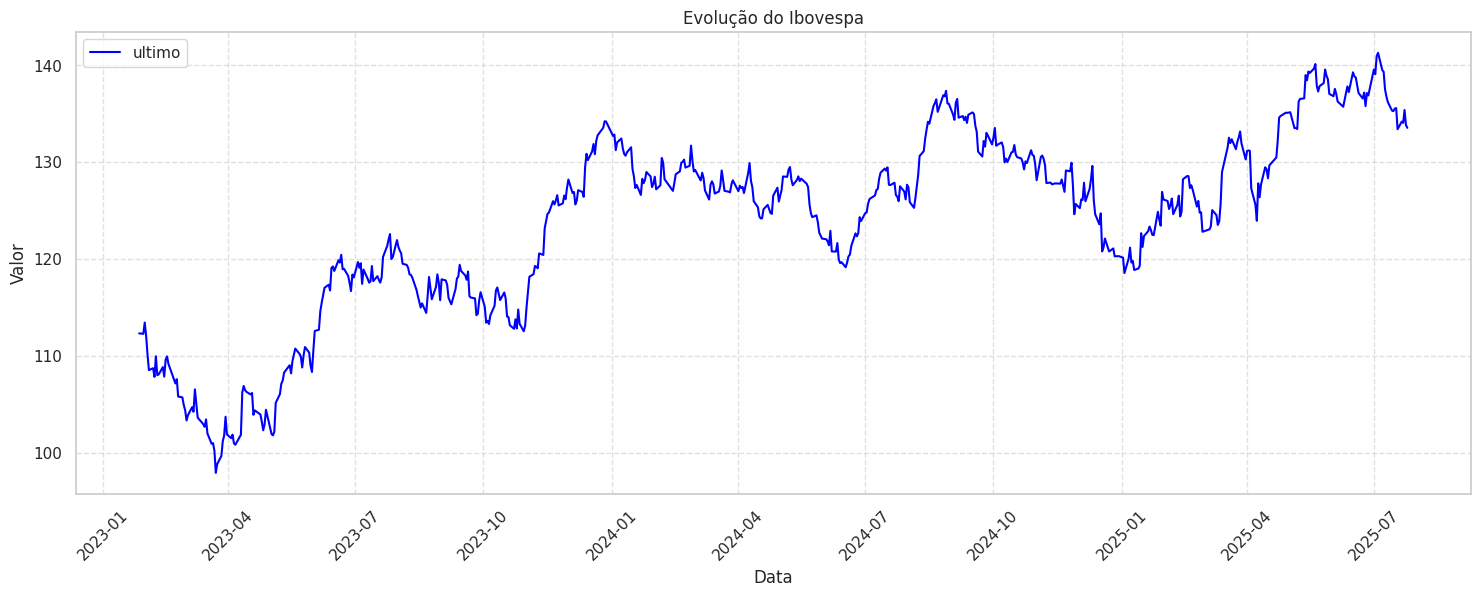

In [74]:
#criando a figura
plt.figure(figsize = (18,6))

sns.lineplot(data = df,x='data',y='fechamento', color = 'blue', label = 'ultimo')

plt.title('Evolução do Ibovespa')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.grid(linestyle ='--', alpha = 0.6)
plt.xticks(rotation=45)
plt.legend()

Ao observar o grafico, é possivel notar que os valores da ibovespa apresenta uma tendencia de crescimento por "queda", ou seja, ela vai subindo e caindo, porem com uma tendencia sempre maior que o ano anterior.

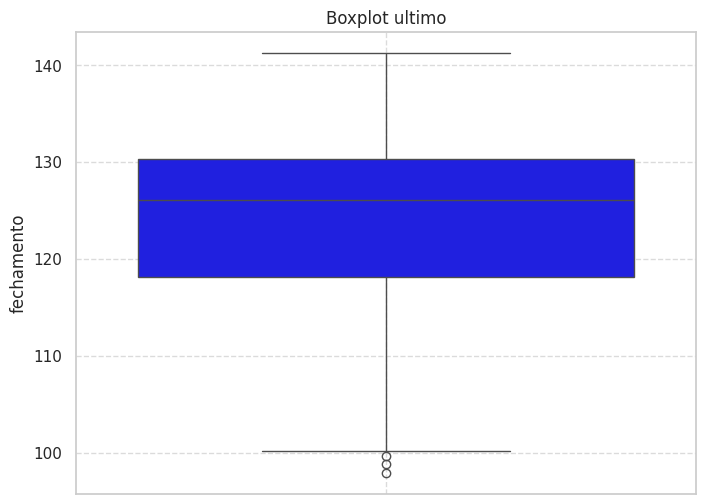

In [75]:
#Criando a imagem

plt.figure(figsize = (8,6))

sns.boxplot(data = df, y = 'fechamento', color = 'blue')
plt.title('Boxplot ultimo')
plt.grid(linestyle ='--', alpha = 0.7)

Ao observar os boxplots, é possivel notar que não há a presença de outliers para as informações de valores de abertura, minimo e maximo do ibovespa

### Analise exploratoria - Series temporais

Para trabalhar com as informações em series temporais, iremos transformar a coluna data em indice

In [76]:
df = df[['data','fechamento']]

#Ajustando o formato de data para a coluna de Data
df['data'] = pd.to_datetime(df['data'], format='%d.%m.%Y')
df = df.set_index('data')
df.head(5)

/tmp/ipython-input-76-3021345461.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['data'] = pd.to_datetime(df['data'], format='%d.%m.%Y')


,fechamento
data,
2025-07-25,133.524
2025-07-24,133.808
2025-07-23,135.368
2025-07-22,134.036
2025-07-21,134.167


As informações do Ibosvesp ocorrem apenas nos dias uteis, dessa forma, para a utilização de algoritmos de series temporais como Arima e Sarima, iremos precisar ajustar as informações dos finais de semana e feriados.

In [77]:
#Ajuste da frequencia do indice
print(df.index.freq)

# Ajuste para a frequencia de dias
df = df.asfreq('D')

df.isnull().sum()

None


,0
fechamento,290


In [78]:
# Preencher valores nulos com o valor do dia anterior
df['fechamento'] = df['fechamento'].fillna(method='ffill')

df.isnull().sum()

/tmp/ipython-input-78-2081789869.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['fechamento'] = df['fechamento'].fillna(method='ffill')


,0
fechamento,0


### Decomposição da serie

In [79]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

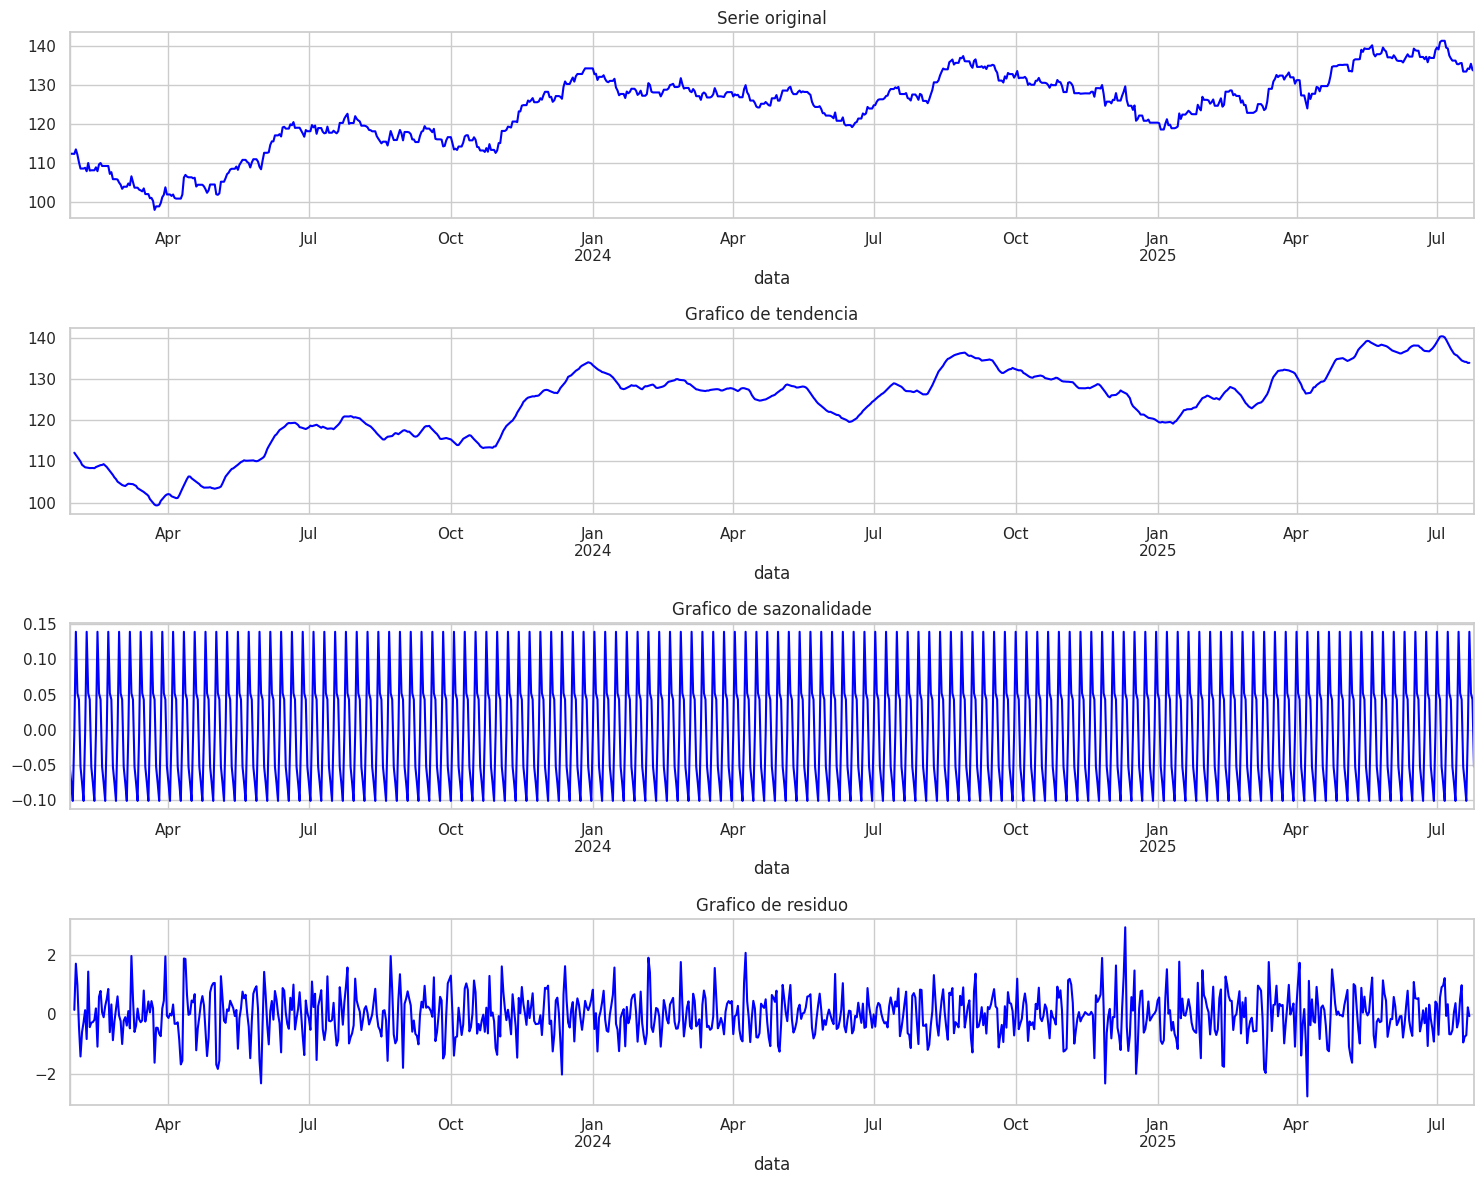

In [80]:
resultados = seasonal_decompose(df, model='additive')

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize = (15,12))

resultados.observed.plot(ax=ax1, color = 'blue')
ax1.set_title('Serie original')

resultados.trend.plot(ax=ax2, color = 'blue')
ax2.set_title('Grafico de tendencia')

resultados.seasonal.plot(ax=ax3, color = 'blue')
ax3.set_title('Grafico de sazonalidade')

resultados.resid.plot(ax=ax4, color = 'blue')
ax4.set_title('Grafico de residuo')

plt.tight_layout()
plt.show()

Visto que o grafico de sazonalidade apresenta picos com amplitudes constantes, iremos usar o parametro "additive".

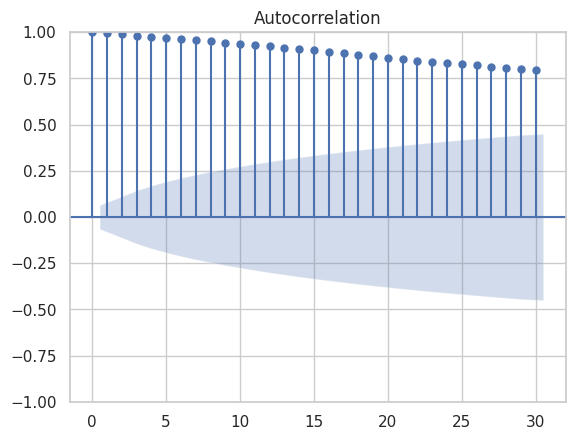

In [81]:
plot_acf(df, alpha = 0.05);

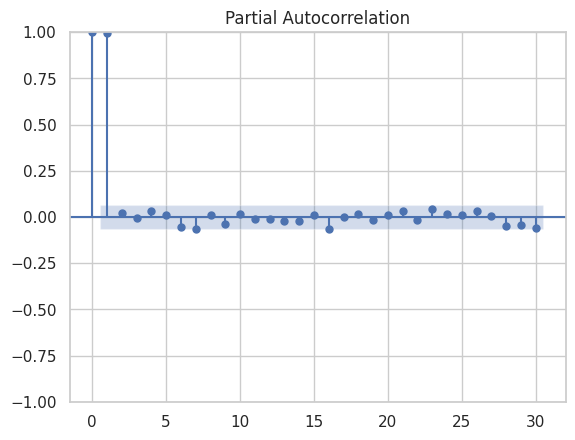

In [82]:
plot_pacf(df, alpha = 0.05);

O grafico da autocorrelação, indica um decaimento lento, dessa forma a serie **não é estacionaria**, logo, é necessario realizarmos a diferenciação.

### Teste de estacionariadade

In [83]:
from statsmodels.tsa.stattools import adfuller

In [84]:
X = df.fechamento.values

result = adfuller(X)

print("Teste ADF")
print(f"Teste Estatístico: {result[0]:.2f}")
print(f"P-Value: {result[1]:.2f}")
print("Valores críticos:")

for key, value in result[4].items():
  print(f"\t{key}: {value:.2f}")

Teste ADF
Teste Estatístico: -1.57
P-Value: 0.50
Valores críticos:
	1%: -3.44
	5%: -2.86
	10%: -2.57


Pelo teste ADF, obtemos um valor de p-value igual a 0,34. Dessa forma, temos um valor maior que 0,05, a nossa **serie não é estacionaria**. Confirmando as a hipotese levantanda pelos graficos anteriores.

### Transformação do serie não estacionaria em estacionaria

In [85]:
df_dif_1 = df.diff(1).dropna()

In [86]:
X = df_dif_1.values

result = adfuller(X)

print("Teste ADF")
print(f"Teste Estatístico: {result[0]:.2f}")
print(f"P-Value: {result[1]:.5f}")
print("Valores críticos:")

for key, value in result[4].items():
  print(f"\t{key}: {value:.2f}")

Teste ADF
Teste Estatístico: -31.29
P-Value: 0.00000
Valores críticos:
	1%: -3.44
	5%: -2.86
	10%: -2.57


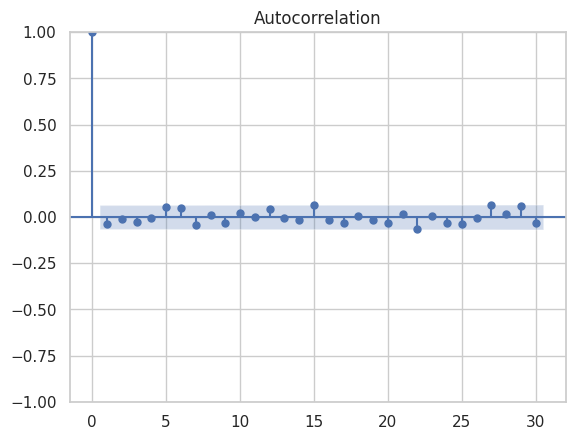

In [87]:
plot_acf(df_dif_1, alpha = 0.05);

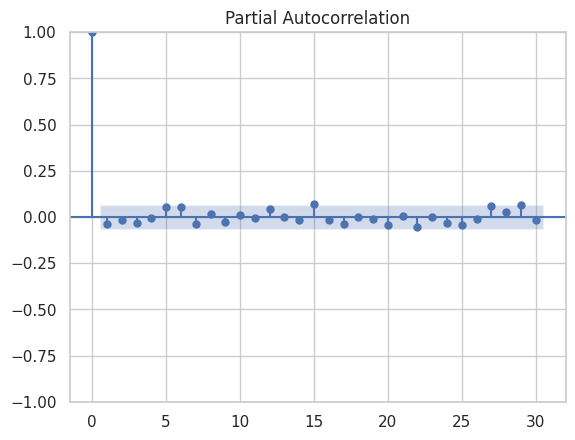

In [88]:
plot_pacf(df_dif_1, alpha = 0.05);

Após realizar a diferenciação, é possivel notar que a informação de autocorrelação apresenta a forma de uma *serie estacionaria*

## Arima

(array([19358., 19448., 19539., 19631., 19723., 19814., 19905., 19997.,
        20089., 20179., 20270.]),
 [Text(19358.0, 0, '2023-01'),
  Text(19448.0, 0, '2023-04'),
  Text(19539.0, 0, '2023-07'),
  Text(19631.0, 0, '2023-10'),
  Text(19723.0, 0, '2024-01'),
  Text(19814.0, 0, '2024-04'),
  Text(19905.0, 0, '2024-07'),
  Text(19997.0, 0, '2024-10'),
  Text(20089.0, 0, '2025-01'),
  Text(20179.0, 0, '2025-04'),
  Text(20270.0, 0, '2025-07')])

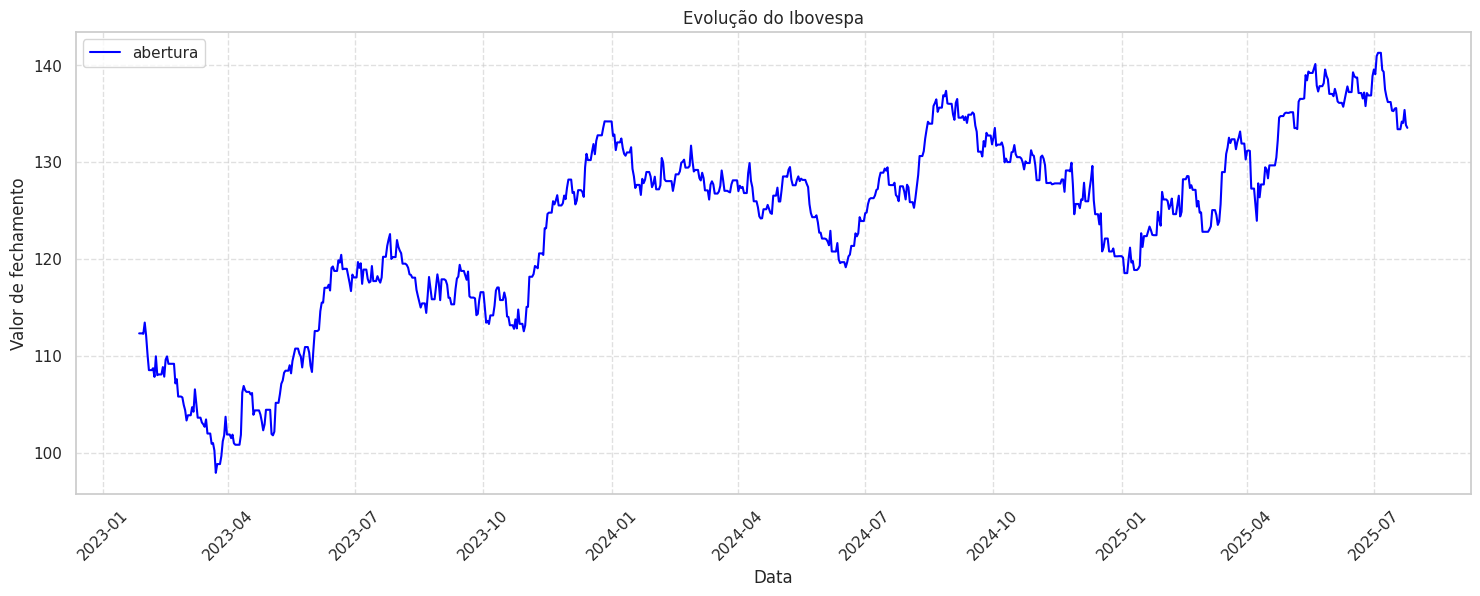

In [89]:
dfArima = df

plt.figure(figsize = (18,6))

sns.lineplot(data = dfArima,x = dfArima.index, y = 'fechamento',color = 'blue',label = 'abertura',markers='o')
# plt.plot(dfArima.index, dfArima['fechamento'], color='blue', label='Abertura')
plt.title('Evolução do Ibovespa')
plt.xlabel('Data')
plt.ylabel('Valor de fechamento')
plt.grid(linestyle ='--', alpha = 0.6)
plt.xticks(rotation=45)

Ao observar o valores de fechamento, é possivel observar uma certa tendencia de aumento com um comportamento de sazonalidade. Dessa forma, a tendencia de aumento indica que a serie não apresenta o comportamento de **serie não estacionaria**

### Separação em treino e teste

In [90]:
# dfArima_dif_1_autoarima = dfArima_dif_1.reset_index()
dfArima_dif_1_autoarima = dfArima.reset_index()
# dfArima_dif_1_autoarima

#  Ajusta o DataFrame para o formato esperado
dfArima_dif_1_autoarima = dfArima_dif_1_autoarima.rename(columns={
    'data': 'ds',         # data
    'fechamento': 'y'      # valor
})

dfArima_dif_1_autoarima['unique_id'] = 'serie_1'

dfArima_dif_1_autoarima.head()

,ds,y,unique_id
0,2023-01-27,112.316,serie_1
1,2023-01-28,112.316,serie_1
2,2023-01-29,112.316,serie_1
3,2023-01-30,112.273,serie_1
4,2023-01-31,113.431,serie_1


In [91]:
# train_size = int(len(dfArima_dif_1_autoarima)*0.75)

#Separação em treino e teste
train = dfArima_dif_1_autoarima.loc[dfArima_dif_1_autoarima['ds'] < '2024-12-04']
test = dfArima_dif_1_autoarima.loc[(dfArima_dif_1_autoarima['ds'] >= '2024-12-04') & (dfArima_dif_1_autoarima['ds'] < '2025-07-30')]


# train = dfArima_dif_1.loc[:dfArima_dif_1_autoarima].to_frame()
# test = dfArima_dif_1.iloc[dfArima_dif_1_autoarima:].to_frame()

In [92]:
# dataCorte = dfArima_dif_1.index[train_size]
# dataCorte

In [93]:
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)

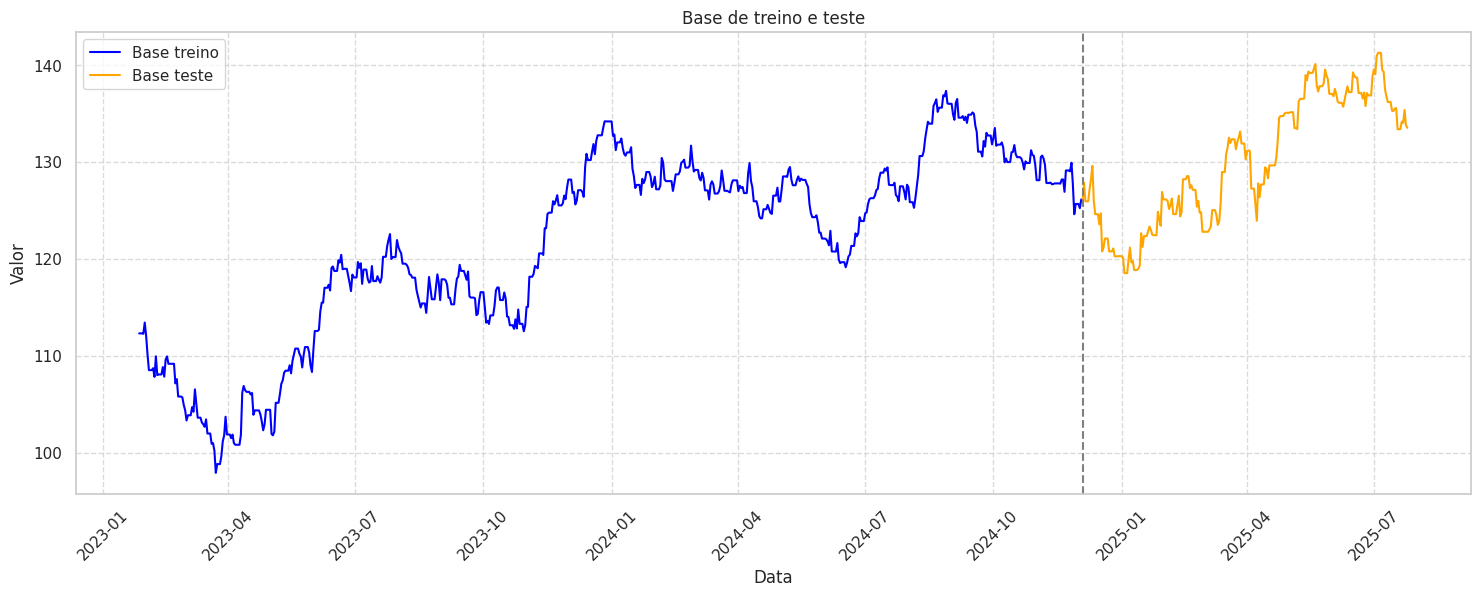

In [94]:
plt.figure(figsize = (18,6))
sns.lineplot(data = train,x = 'ds', y = 'y',color = 'blue',label = 'Base treino')
sns.lineplot(data = test,x = 'ds', y = 'y',color = 'orange',label = 'Base teste')
plt.axvline(pd.to_datetime('2024-12-04'), color='gray', ls='--')
plt.grid(linestyle ='--', alpha = 0.7)
plt.title('Base de treino e teste')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.legend()
plt.xticks(rotation=45)
plt.show()

### AutoArima

In [95]:
!pip install statsforecast

In [96]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsforecast.models import Naive, SeasonalNaive, SeasonalWindowAverage, AutoARIMA

In [97]:
train['y'] = train['y'].ffill()

/tmp/ipython-input-97-3969252951.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['y'] = train['y'].ffill()


In [98]:
train['ds'] = pd.to_datetime(train['ds'])
diffs = train.sort_values('ds')['ds'].diff().value_counts()
print(diffs)

ds
1 days    676
Name: count, dtype: int64


/tmp/ipython-input-98-4141097848.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['ds'] = pd.to_datetime(train['ds'])


In [99]:
model = StatsForecast(models=[AutoARIMA(season_length=1, d=0)], freq='D', n_jobs=-1)
model.fit(train)

StatsForecast(models=[AutoARIMA])

In [100]:
forecast = model.predict(h=30, level=[30])
forecast.head(5)

,unique_id,ds,AutoARIMA,AutoARIMA-lo-30,AutoARIMA-hi-30
0,serie_1,2024-12-04,126.138999,125.794012,126.483985
1,serie_1,2024-12-05,126.138998,125.651113,126.626882
2,serie_1,2024-12-06,126.138997,125.541462,126.736531
3,serie_1,2024-12-07,126.138995,125.449022,126.828968
4,serie_1,2024-12-08,126.138994,125.367581,126.910407


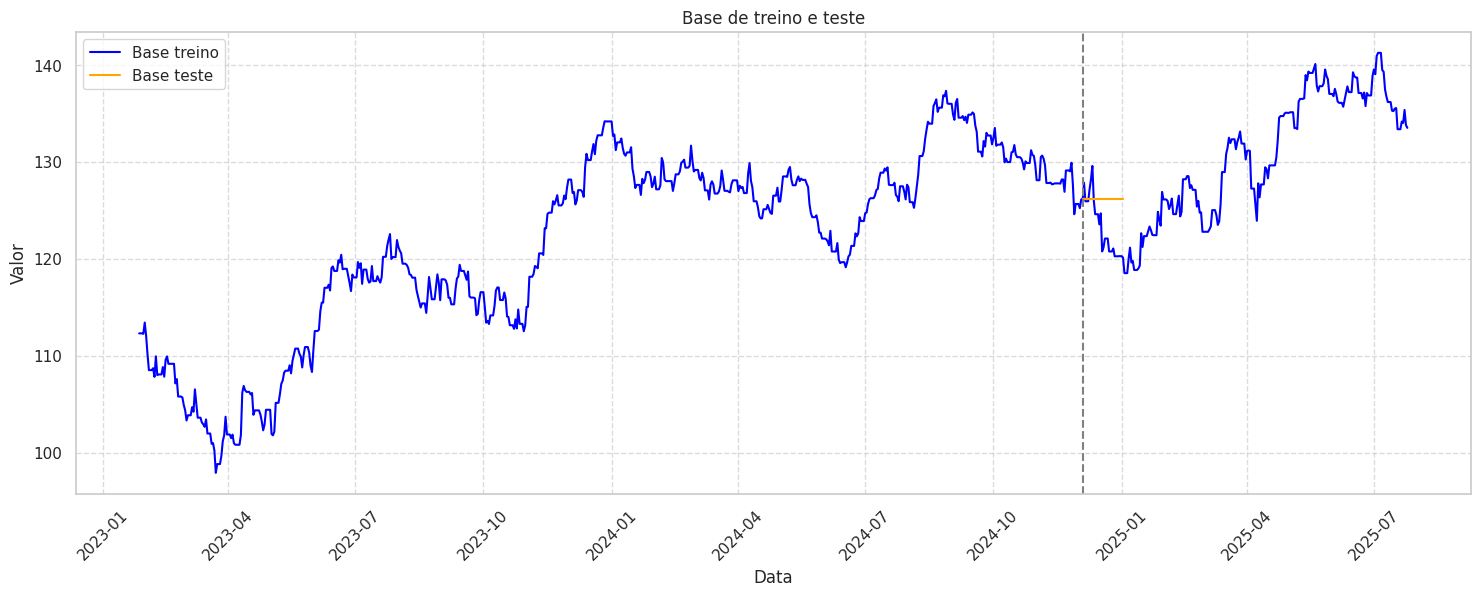

In [101]:
plt.figure(figsize = (18,6))
sns.lineplot(data = dfArima_dif_1_autoarima,x = 'ds', y = 'y',color = 'blue',label = 'Base treino')
# sns.lineplot(data = test,x = 'ds', y = 'y',color = 'orange',label = 'Base teste')
sns.lineplot(data = forecast,x = 'ds', y = 'AutoARIMA',color = 'orange',label = 'Base teste')
plt.axvline(pd.to_datetime('2024-12-04'), color='gray', ls='--')
plt.grid(linestyle ='--', alpha = 0.7)
plt.title('Base de treino e teste')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.legend()
plt.xticks(rotation=45)
plt.show()

## Analisando os valores nulos

In [102]:
# Ajuste para a frequencia de dias
# dfXgboost = dfXgboost.asfreq('D')
#
# dfXgboost.isnull().sum()

Uma vez que os finais de semana e feriados serão iguais ao valor anterior, iremos adicionar uma coluna de dia_util na nossa base, dessa forma, o algoritmo poderá utilizar a mesma para melhorar o modelo

In [103]:
# dfXgboost['dia_util'] = dfXgboost['fechamento'].isnull().astype(int)

In [104]:
# dfXgboost['fechamento'] = dfXgboost['fechamento'].fillna(method='ffill')
# dfXgboost['abertura'] = dfXgboost['abertura'].fillna(method='ffill')
# dfXgboost['maxima'] = dfXgboost['maxima'].fillna(method='ffill')
# dfXgboost['minima'] = dfXgboost['minima'].fillna(method='ffill')

# dfXgboost.isnull().sum()

## XGBoosting

In [105]:
import xgboost as xgb
from xgboost import XGBRegressor
import datetime as dt

In [106]:
dfXgboost = pd.read_csv('/content/Dados Históricos - Ibovespa.csv')

dfXgboost.head(5)

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,25.07.2025,133.524,133.820,134.204,133.285,"5,56B","-0,21%"
1,24.07.2025,133.808,135.357,135.363,133.648,"5,98B","-1,15%"
2,23.07.2025,135.368,134.036,135.782,133.676,"6,53B","0,99%"
3,22.07.2025,134.036,134.180,135.300,133.986,"7,05B","-0,10%"
4,21.07.2025,134.167,133.382,134.865,133.367,"6,73B","0,59%"


In [107]:
dfXgboost = dfXgboost[['Data','Último','Abertura','Máxima','Mínima']]
dfXgboost = dfXgboost.rename(columns={'Data':'data','Último':'fechamento','Abertura':'abertura','Máxima':'maxima','Mínima':'minima'})

#Ajustando o formato de data para a coluna de Data
dfXgboost['data'] = pd.to_datetime(dfXgboost['data'], format='%d.%m.%Y')
dfXgboost = dfXgboost.set_index('data')

dfXgboost = dfXgboost.sort_index(ascending=True)
dfXgboost.head(5)

,fechamento,abertura,maxima,minima
data,,,,
2023-01-27,112.316,114.178,114.191,112.044
2023-01-30,112.273,112.319,112.920,111.824
2023-01-31,113.431,112.273,113.691,112.145
2023-02-01,112.074,113.430,113.598,110.729
2023-02-02,110.141,112.072,112.943,109.747


In [108]:
print(dfXgboost.index.min())
print(dfXgboost.index.max())

2023-01-27 00:00:00
2025-07-25 00:00:00


### Criação das features

In [109]:
# Adição das variveis de temporais

dfXgboost["diadasemana"] = dfXgboost.index.dayofweek
dfXgboost["diadomes"] = dfXgboost.index.day
dfXgboost["mes"] = dfXgboost.index.month
dfXgboost["semanadoano"] = dfXgboost.index.isocalendar().week
dfXgboost["ano"] = dfXgboost.index.year

dfXgboost.head(5)

,fechamento,abertura,maxima,minima,diadasemana,diadomes,mes,semanadoano,ano
data,,,,,,,,,
2023-01-27,112.316,114.178,114.191,112.044,4,27,1,4,2023
2023-01-30,112.273,112.319,112.920,111.824,0,30,1,5,2023
2023-01-31,113.431,112.273,113.691,112.145,1,31,1,5,2023
2023-02-01,112.074,113.430,113.598,110.729,2,1,2,5,2023
2023-02-02,110.141,112.072,112.943,109.747,3,2,2,5,2023


In [169]:
# Deslocamento os valores do fechamento, abertura, maxima e minina

dfXgboost['fechamento_1'] = dfXgboost['fechamento'].shift(1)
dfXgboost['fechamento_2'] = dfXgboost['fechamento'].shift(2)
# dfXgboost['fechamento_3'] = dfXgboost['fechamento'].shift(3)
# dfXgboost['fechamento_4'] = dfXgboost['fechamento'].shift(4)
# dfXgboost['fechamento_7'] = dfXgboost['fechamento'].shift(7)
# dfXgboost['fechamento_30'] = dfXgboost['fechamento'].shift(30)

dfXgboost['mediaFechamento_2'] = dfXgboost['fechamento'].shift(1).rolling(2).mean()
# dfXgboost['mediaFechamento_15'] = dfXgboost['fechamento'].shift(1).rolling(2).mean()
# dfXgboost['mediaFechamento_30'] = dfXgboost['fechamento'].shift(1).rolling(30).mean()

dfXgboost['abertura_1'] = dfXgboost['abertura'].shift(1)
dfXgboost['abertura_2'] = dfXgboost['abertura'].shift(2)
# dfXgboost['abertura_7'] = dfXgboost['abertura'].shift(7)
# dfXgboost['abertura_30'] = dfXgboost['abertura'].shift(30)

dfXgboost['MediaAberturaFechamento_1'] = (dfXgboost['fechamento_1']  + dfXgboost['abertura_1'])/2
dfXgboost['MediaAberturaFechamento_2'] = (dfXgboost['fechamento_2']  + dfXgboost['abertura_2'])/2

dfXgboost['maxima_1'] = dfXgboost['maxima'].shift(1)
dfXgboost['maxima_2'] = dfXgboost['maxima'].shift(2)
# dfXgboost['maxima_7'] = dfXgboost['maxima'].shift(7)
# dfXgboost['maxima_30'] = dfXgboost['maxima'].shift(30)

dfXgboost['minima_1'] = dfXgboost['minima'].shift(1)
dfXgboost['minima_2'] = dfXgboost['minima'].shift(2)
# dfXgboost['minima_7'] = dfXgboost['minima'].shift(7)
# dfXgboost['minima_30'] = dfXgboost['minima'].shift(30)

dfXgboost['MediaMinimaMaxima_1'] = (dfXgboost['minima_1']  + dfXgboost['maxima_1'])/2
dfXgboost['MediaMinimaMaxima_2'] = (dfXgboost['minima_2']  + dfXgboost['maxima_2'])/2
# dfXgboost['MediaMinimaMaxima_7'] = (dfXgboost['minima_7']  + dfXgboost['maxima_7'])/2

#Remoção das linhas nulos do lag
dfXgboost = dfXgboost.dropna()

In [170]:
# Adição da bandas de posição


dfXgboost['media'] = dfXgboost['fechamento_1'].rolling(window=2).mean()
dfXgboost['std'] = dfXgboost['fechamento_1'].rolling(window=2).std()

dfXgboost['banda_superior'] = dfXgboost['media'] + 2 * dfXgboost['std']
dfXgboost['banda_inferior'] = dfXgboost['media'] - 2 * dfXgboost['std']

dfXgboost['BB_position'] = (dfXgboost['fechamento_1'] - dfXgboost['banda_inferior']) / (dfXgboost['banda_superior'] - dfXgboost['banda_inferior'])

/tmp/ipython-input-170-1979845512.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfXgboost['media'] = dfXgboost['fechamento_1'].rolling(window=2).mean()
/tmp/ipython-input-170-1979845512.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfXgboost['std'] = dfXgboost['fechamento_1'].rolling(window=2).std()
/tmp/ipython-input-170-1979845512.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

In [171]:
#Adição das variaveis de tendencias

def tendencia(x):
    if x > 0:
        return 1
    else:
        return 0

dfXgboost['Tendecias_fechamento_1'] = dfXgboost['fechamento_1'].diff().apply(tendencia)
dfXgboost['Tendecias_abertura_1'] = dfXgboost['abertura_1'].diff().apply(tendencia)
dfXgboost['Tendecias_maxima_1'] = dfXgboost['maxima_1'].diff().apply(tendencia)
dfXgboost['Tendecias_minima_1'] = dfXgboost['fechamento_1'].diff().apply(tendencia)

dfXgboost = dfXgboost[1:len(dfXgboost)+1]

/tmp/ipython-input-171-3645576216.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfXgboost['Tendecias_fechamento_1'] = dfXgboost['fechamento_1'].diff().apply(tendencia)
/tmp/ipython-input-171-3645576216.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfXgboost['Tendecias_abertura_1'] = dfXgboost['abertura_1'].diff().apply(tendencia)
/tmp/ipython-input-171-3645576216.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

### Separação em treino/teste

Para o algoritmo, iremos testar algumas janelas temporais:

1.  Últimos 6 meses
2.  Últimos 12 meses
3.  Últimos 18 meses
4.  Últimos 24 meses

In [172]:
dfXgboost_6meses = dfXgboost.tail(140)
dfXgboost_12meses = dfXgboost.tail(288)
dfXgboost_18meses = dfXgboost.tail(392)
dfXgboost_24meses = dfXgboost.tail(516)


print("Data de inicio do dataframe dfXgboost_6meses:",dfXgboost_6meses.index.min())
print("Data de inicio do dataframe dfXgboost_6meses:",dfXgboost_12meses.index.min())
print("Data de inicio do dataframe dfXgboost_18meses:",dfXgboost_18meses.index.min())
print("Data de inicio do dataframe dfXgboost_24meses:",dfXgboost_24meses.index.min())

Data de inicio do dataframe dfXgboost_6meses: 2025-01-03 00:00:00
Data de inicio do dataframe dfXgboost_6meses: 2024-06-03 00:00:00
Data de inicio do dataframe dfXgboost_18meses: 2024-01-02 00:00:00
Data de inicio do dataframe dfXgboost_24meses: 2023-07-03 00:00:00


In [173]:
train_size_6meses =  int(len(dfXgboost_6meses)*0.80)
train_size_12meses = int(len(dfXgboost_12meses)*0.80)
train_size_18meses = int(len(dfXgboost_18meses)*0.80)
train_size_24meses = int(len(dfXgboost_24meses)*0.80)

# dfXgboost_24meses.index.min()

In [174]:
#Separação em treino e teste
#------ 6 meses --------------------
train_6meses = dfXgboost_6meses.iloc[:-30]
test_6meses  = dfXgboost_6meses.iloc[-30:]

# train_6meses = dfXgboost_6meses.iloc[:train_size_6meses]
# test_6meses  = dfXgboost_6meses.iloc[train_size_6meses:]

#------ 12 meses --------------------
train_12meses = dfXgboost_12meses.iloc[:-30]
test_12meses  = dfXgboost_12meses.iloc[-30:]
# train_12meses = dfXgboost_12meses.iloc[:train_size_12meses]
# test_12meses  = dfXgboost_12meses.iloc[train_size_12meses:]

#------ 18 meses --------------------
train_18meses = dfXgboost_18meses.iloc[:-30]
test_18meses  = dfXgboost_18meses.iloc[-30:]
# train_18meses = dfXgboost_18meses.iloc[:train_size_18meses]
# test_18meses  = dfXgboost_18meses.iloc[train_size_18meses:]


#------ 24 meses --------------------
train_24meses = dfXgboost_24meses.iloc[:-30]
test_24meses  = dfXgboost_24meses.iloc[-30:]
# train_24meses = dfXgboost_24meses.iloc[:train_size_24meses]
# test_24meses  = dfXgboost_24meses.iloc[train_size_24meses:]

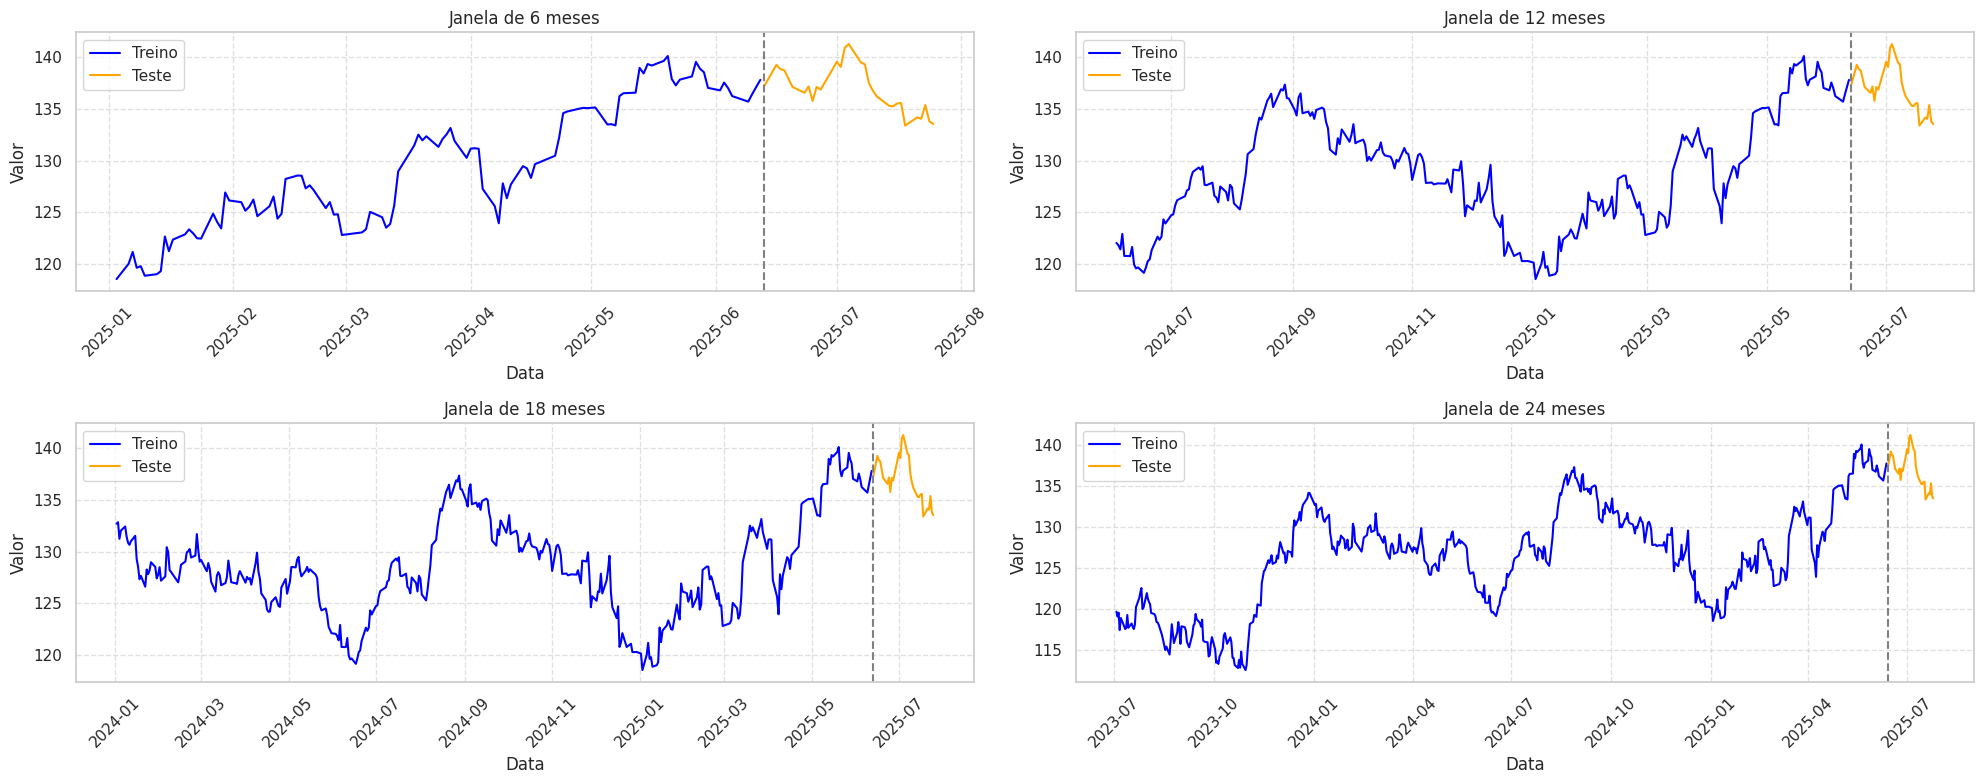

In [175]:
# Criar a grade 2x2 de subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 8))
axes = axes.flatten()

# Listas com dados e títulos
treinos = [train_6meses, train_12meses, train_18meses, train_24meses]
testes  = [test_6meses,  test_12meses,  test_18meses,  test_24meses]
titulos = ['Janela de 6 meses', 'Janela de 12 meses', 'Janela de 18 meses', 'Janela de 24 meses']

# Plot
for i in range(4):
    ax = axes[i]
    sns.lineplot(data=treinos[i], x=treinos[i].index, y='fechamento', color='blue', label='Treino', ax=ax)
    sns.lineplot(data=testes[i],  x=testes[i].index,  y='fechamento', color='orange', label='Teste', ax=ax)
    ax.axvline(testes[i].index.min(), color='gray', ls='--')  # << corrigido aqui
    ax.set_title(titulos[i])
    ax.set_xlabel('Data')
    ax.set_ylabel('Valor')
    ax.legend()
    ax.grid(linestyle='--', alpha=0.6)
    ax.tick_params(axis='x', rotation=45)


plt.tight_layout()
plt.show()

In [176]:
varTreino = ['diadasemana',
             'diadomes',
             'mes',
             'semanadoano',
             'ano',
             'fechamento_1',
             'fechamento_2',
            #  'fechamento_3',
            #  'fechamento_4',
            #  'fechamento_30',
             'abertura_1',
            #  'abertura_2',
            #  'MediaAberturaFechamento_1',
            #  'MediaAberturaFechamento_2',
            #  'abertura_7',
            #  'abertura_30',
             'mediaFechamento_2',
            #  'mediaFechamento_15',
            #  'mediaFechamento_30',
             'maxima_1',
             'maxima_2',
            #  'maxima_30',
             'minima_1',
             'minima_2',
            #  'minima_30',
            #  'MediaMinimaMaxima_1',
            #  'MediaMinimaMaxima_2',
             'Tendecias_fechamento_1',
             'Tendecias_abertura_1',
             'Tendecias_maxima_1',
             'Tendecias_minima_1',
             'BB_position'
            #  'MediaMinimaMaxima_7'
            #  'dia_util'
             ]

#------ 6 meses ----------------------------
X_train_6meses = train_6meses[varTreino]
y_train_6meses = train_6meses['fechamento']

X_test_6meses = test_6meses[varTreino]
y_test_6meses = test_6meses['fechamento']

#------ 12 meses ----------------------------
X_train_12meses = train_12meses[varTreino]
y_train_12meses = train_12meses['fechamento']

X_test_12meses = test_12meses[varTreino]
y_test_12meses = test_12meses['fechamento']

#------ 18 meses ----------------------------
X_train_18meses = train_18meses[varTreino]
y_train_18meses = train_18meses['fechamento']

X_test_18meses = test_18meses[varTreino]
y_test_18meses = test_18meses['fechamento']

#------ 24 meses ----------------------------
X_train_24meses = train_24meses[varTreino]
y_train_24meses = train_24meses['fechamento']

X_test_24meses = test_24meses[varTreino]
y_test_24meses = test_24meses['fechamento']

In [177]:
model_6meses = xgb.XGBRegressor(base_score=0.5,
                          booster='gbtree',
                          # random_state = 42,
                          n_estimators=2000,
                          # early_stopping_rounds=100,
                          objective='reg:squarederror',
                          max_depth=8,
                          learning_rate=0.01)

model_6meses = model_6meses.fit(X_train_6meses, y_train_6meses,
        eval_set=[(X_train_6meses, y_train_6meses), (X_test_6meses, y_test_6meses)],
        verbose=100)

[0]	validation_0-rmse:127.92971	validation_1-rmse:135.21689
[100]	validation_0-rmse:47.57333	validation_1-rmse:54.05465
[200]	validation_0-rmse:17.88020	validation_1-rmse:21.15869
[300]	validation_0-rmse:6.82027	validation_1-rmse:8.38478
[400]	validation_0-rmse:2.73933	validation_1-rmse:3.54883
[500]	validation_0-rmse:1.20847	validation_1-rmse:1.87267
[600]	validation_0-rmse:0.57937	validation_1-rmse:1.48678
[700]	validation_0-rmse:0.29875	validation_1-rmse:1.40905
[800]	validation_0-rmse:0.15843	validation_1-rmse:1.41411
[900]	validation_0-rmse:0.08764	validation_1-rmse:1.41770
[1000]	validation_0-rmse:0.05138	validation_1-rmse:1.41097
[1100]	validation_0-rmse:0.03055	validation_1-rmse:1.40622
[1200]	validation_0-rmse:0.01855	validation_1-rmse:1.40269
[1300]	validation_0-rmse:0.01148	validation_1-rmse:1.40098
[1400]	validation_0-rmse:0.00706	validation_1-rmse:1.39995
[1500]	validation_0-rmse:0.00441	validation_1-rmse:1.39964
[1600]	validation_0-rmse:0.00271	validation_1-rmse:1.39950
[

In [178]:
model_12meses = xgb.XGBRegressor(base_score=0.5,
                          booster='gbtree',
                          # random_state = 42,
                          n_estimators=1200,
                          # early_stopping_rounds=100,
                          objective='reg:squarederror',
                          max_depth=8,
                          learning_rate=0.01)

model_12meses = model_12meses.fit(X_train_12meses, y_train_12meses,
        eval_set=[(X_train_12meses, y_train_12meses), (X_test_12meses, y_test_12meses)],
        verbose=100)

[0]	validation_0-rmse:127.24809	validation_1-rmse:135.21674
[100]	validation_0-rmse:46.97773	validation_1-rmse:53.45924
[200]	validation_0-rmse:17.44414	validation_1-rmse:21.12503
[300]	validation_0-rmse:6.56297	validation_1-rmse:8.43575
[400]	validation_0-rmse:2.61157	validation_1-rmse:3.60688
[500]	validation_0-rmse:1.18321	validation_1-rmse:2.03444
[600]	validation_0-rmse:0.65574	validation_1-rmse:1.67535
[700]	validation_0-rmse:0.45246	validation_1-rmse:1.57919
[800]	validation_0-rmse:0.33945	validation_1-rmse:1.55907
[900]	validation_0-rmse:0.26336	validation_1-rmse:1.54863
[1000]	validation_0-rmse:0.20893	validation_1-rmse:1.54149
[1100]	validation_0-rmse:0.16399	validation_1-rmse:1.53479
[1199]	validation_0-rmse:0.11697	validation_1-rmse:1.53516


In [179]:
model_18meses = xgb.XGBRegressor(base_score=0.5,
                          booster='gbtree',
                          # random_state = 42,
                          n_estimators=2000,
                          # early_stopping_rounds=100,
                          objective='reg:squarederror',
                          max_depth=8,
                          learning_rate=0.01)

model_18meses = model_18meses.fit(X_train_18meses, y_train_18meses,
        eval_set=[(X_train_18meses, y_train_18meses), (X_test_18meses, y_test_18meses)],
        verbose=100)

[0]	validation_0-rmse:126.93260	validation_1-rmse:135.21822
[100]	validation_0-rmse:46.76499	validation_1-rmse:53.75680
[200]	validation_0-rmse:17.31634	validation_1-rmse:21.27629
[300]	validation_0-rmse:6.48888	validation_1-rmse:8.48964
[400]	validation_0-rmse:2.57168	validation_1-rmse:3.58461
[500]	validation_0-rmse:1.17339	validation_1-rmse:1.97692
[600]	validation_0-rmse:0.66067	validation_1-rmse:1.58221
[700]	validation_0-rmse:0.46707	validation_1-rmse:1.53680
[800]	validation_0-rmse:0.34830	validation_1-rmse:1.53364
[900]	validation_0-rmse:0.27519	validation_1-rmse:1.52533
[1000]	validation_0-rmse:0.20279	validation_1-rmse:1.53930
[1100]	validation_0-rmse:0.16034	validation_1-rmse:1.54205
[1200]	validation_0-rmse:0.13212	validation_1-rmse:1.54712
[1300]	validation_0-rmse:0.11296	validation_1-rmse:1.55288
[1400]	validation_0-rmse:0.08738	validation_1-rmse:1.55476
[1500]	validation_0-rmse:0.07244	validation_1-rmse:1.55375
[1600]	validation_0-rmse:0.05804	validation_1-rmse:1.55355
[

In [180]:
model_24meses = xgb.XGBRegressor(base_score=0.5,
                          booster='gbtree',
                          # random_state = 42,
                          n_estimators=2000,
                          # early_stopping_rounds=100,
                          objective='reg:squarederror',
                          max_depth=8,
                          learning_rate=0.01)

model_24meses = model_24meses.fit(X_train_24meses, y_train_24meses,
        eval_set=[(X_train_24meses, y_train_24meses), (X_test_24meses, y_test_24meses)],
        verbose=100)

[0]	validation_0-rmse:124.80518	validation_1-rmse:135.23942
[100]	validation_0-rmse:45.95997	validation_1-rmse:53.56365
[200]	validation_0-rmse:16.98966	validation_1-rmse:21.20385
[300]	validation_0-rmse:6.35527	validation_1-rmse:8.48373
[400]	validation_0-rmse:2.52660	validation_1-rmse:3.62801
[500]	validation_0-rmse:1.18394	validation_1-rmse:2.10512
[600]	validation_0-rmse:0.68581	validation_1-rmse:1.67559
[700]	validation_0-rmse:0.46031	validation_1-rmse:1.65930
[800]	validation_0-rmse:0.36540	validation_1-rmse:1.63708
[900]	validation_0-rmse:0.31206	validation_1-rmse:1.62939
[1000]	validation_0-rmse:0.25438	validation_1-rmse:1.62007
[1100]	validation_0-rmse:0.21028	validation_1-rmse:1.61502
[1200]	validation_0-rmse:0.17192	validation_1-rmse:1.61345
[1300]	validation_0-rmse:0.14657	validation_1-rmse:1.61004
[1400]	validation_0-rmse:0.12469	validation_1-rmse:1.60862
[1500]	validation_0-rmse:0.10672	validation_1-rmse:1.60796
[1600]	validation_0-rmse:0.08394	validation_1-rmse:1.60655
[

In [181]:
r_square = model_6meses.score(X_test_6meses, y_test_6meses)*100
print('Modelo de 6 meses: R² da Random Forest no teste: {0:.2f}%'.format(r_square))

r_square = model_12meses.score(X_test_12meses, y_test_12meses)*100
print('Modelo de 12 meses: R² da Random Forest no teste: {0:.2f}%'.format(r_square))

r_square = model_18meses.score(X_test_18meses, y_test_18meses)*100
print('Modelo de 18 meses: R² da Random Forest no teste: {0:.2f}%'.format(r_square))

r_square = model_24meses.score(X_test_24meses, y_test_24meses)*100
print('Modelo de 24 meses: R² da Random Forest no teste: {0:.2f}%'.format(r_square))

Modelo de 6 meses: R² da Random Forest no teste: 57.60%
Modelo de 12 meses: R² da Random Forest no teste: 48.96%
Modelo de 18 meses: R² da Random Forest no teste: 47.91%
Modelo de 24 meses: R² da Random Forest no teste: 44.27%


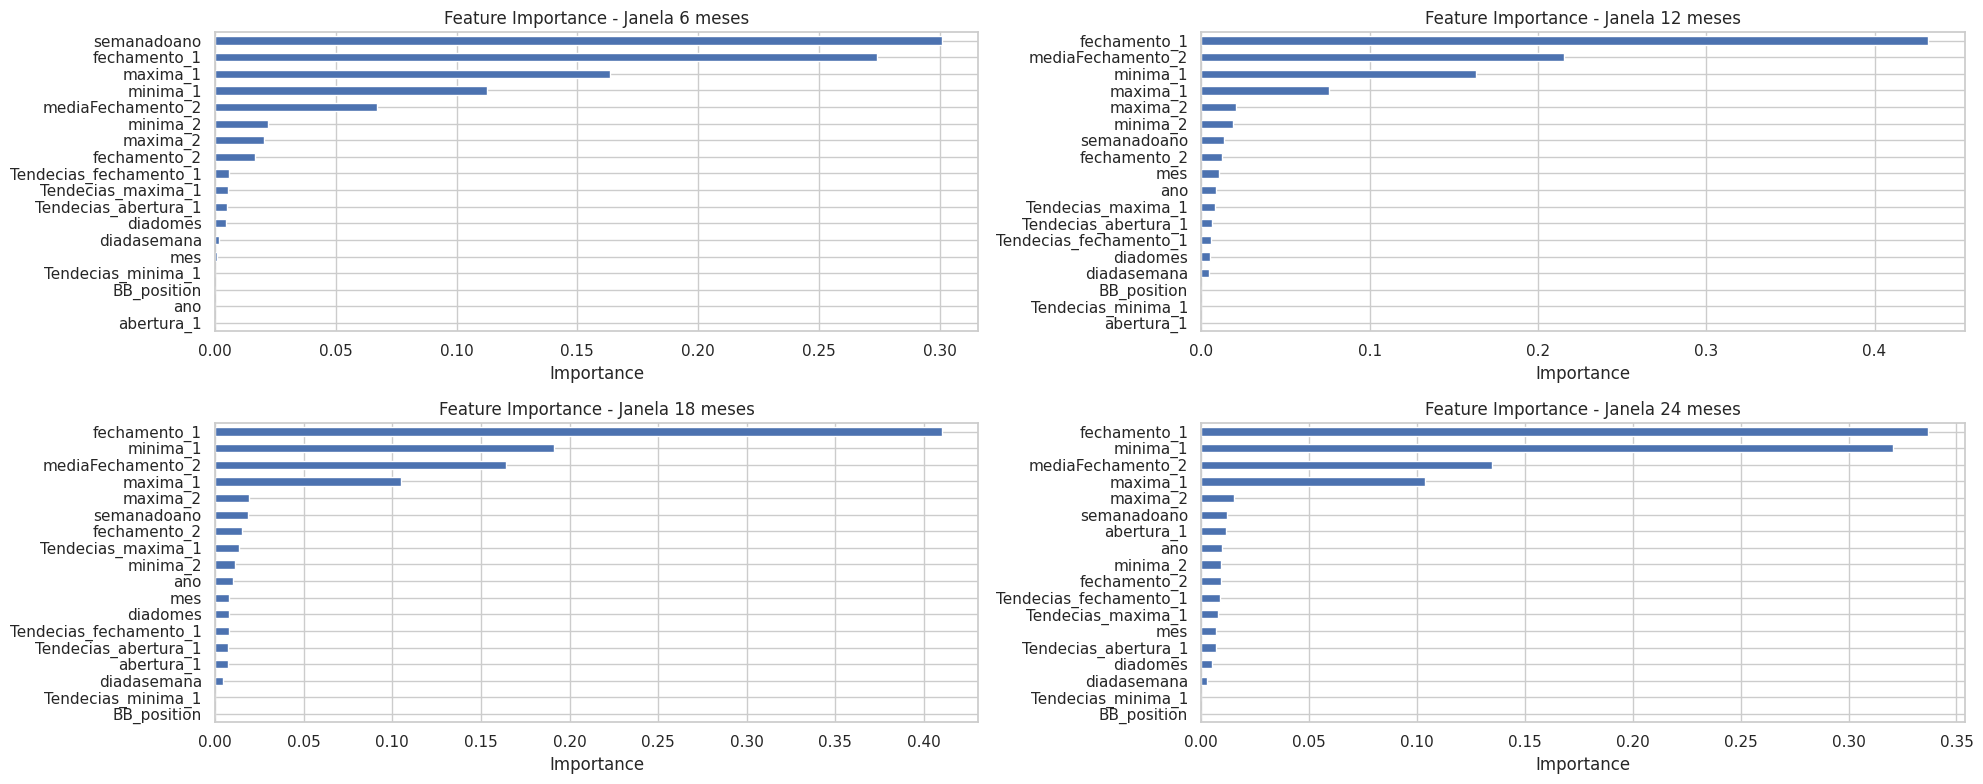

In [182]:
# Dicionário com modelos e nomes
modelos = {
    '6 meses': model_6meses,
    '12 meses': model_12meses,
    '18 meses': model_18meses,
    '24 meses': model_24meses
}

fig, axes = plt.subplots(2, 2, figsize=(20, 8))
axes = axes.flatten()

for i, (nome, model) in enumerate(modelos.items()):
    fi = pd.DataFrame(
        data=model.feature_importances_,
        index=model.feature_names_in_,
        columns=['importance']
    )

    fi = fi.sort_values('importance')

    fi.plot(kind='barh', ax=axes[i], legend=False)
    axes[i].set_title(f'Feature Importance - Janela {nome}')
    axes[i].set_xlabel('Importance')

plt.tight_layout()
plt.show()

In [183]:
test_6meses['prediction_6meses'] = model_6meses.predict(X_test_6meses)
test_12meses['prediction_12meses'] = model_12meses.predict(X_test_12meses)
test_18meses['prediction_18meses'] = model_18meses.predict(X_test_18meses)
test_24meses['prediction_24meses'] = model_24meses.predict(X_test_24meses)

/tmp/ipython-input-183-2864820547.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_6meses['prediction_6meses'] = model_6meses.predict(X_test_6meses)
/tmp/ipython-input-183-2864820547.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_12meses['prediction_12meses'] = model_12meses.predict(X_test_12meses)
/tmp/ipython-input-183-2864820547.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [184]:
dfXgboostfinal = dfXgboost[['fechamento']]

In [185]:
dfXgboostfinal = dfXgboostfinal.merge(test_6meses[['prediction_6meses']], how='left', left_index=True, right_index=True)
dfXgboostfinal = dfXgboostfinal.merge(test_12meses[['prediction_12meses']], how='left', left_index=True, right_index=True)
dfXgboostfinal = dfXgboostfinal.merge(test_18meses[['prediction_18meses']], how='left', left_index=True, right_index=True)
dfXgboostfinal = dfXgboostfinal.merge(test_24meses[['prediction_24meses']], how='left', left_index=True, right_index=True)

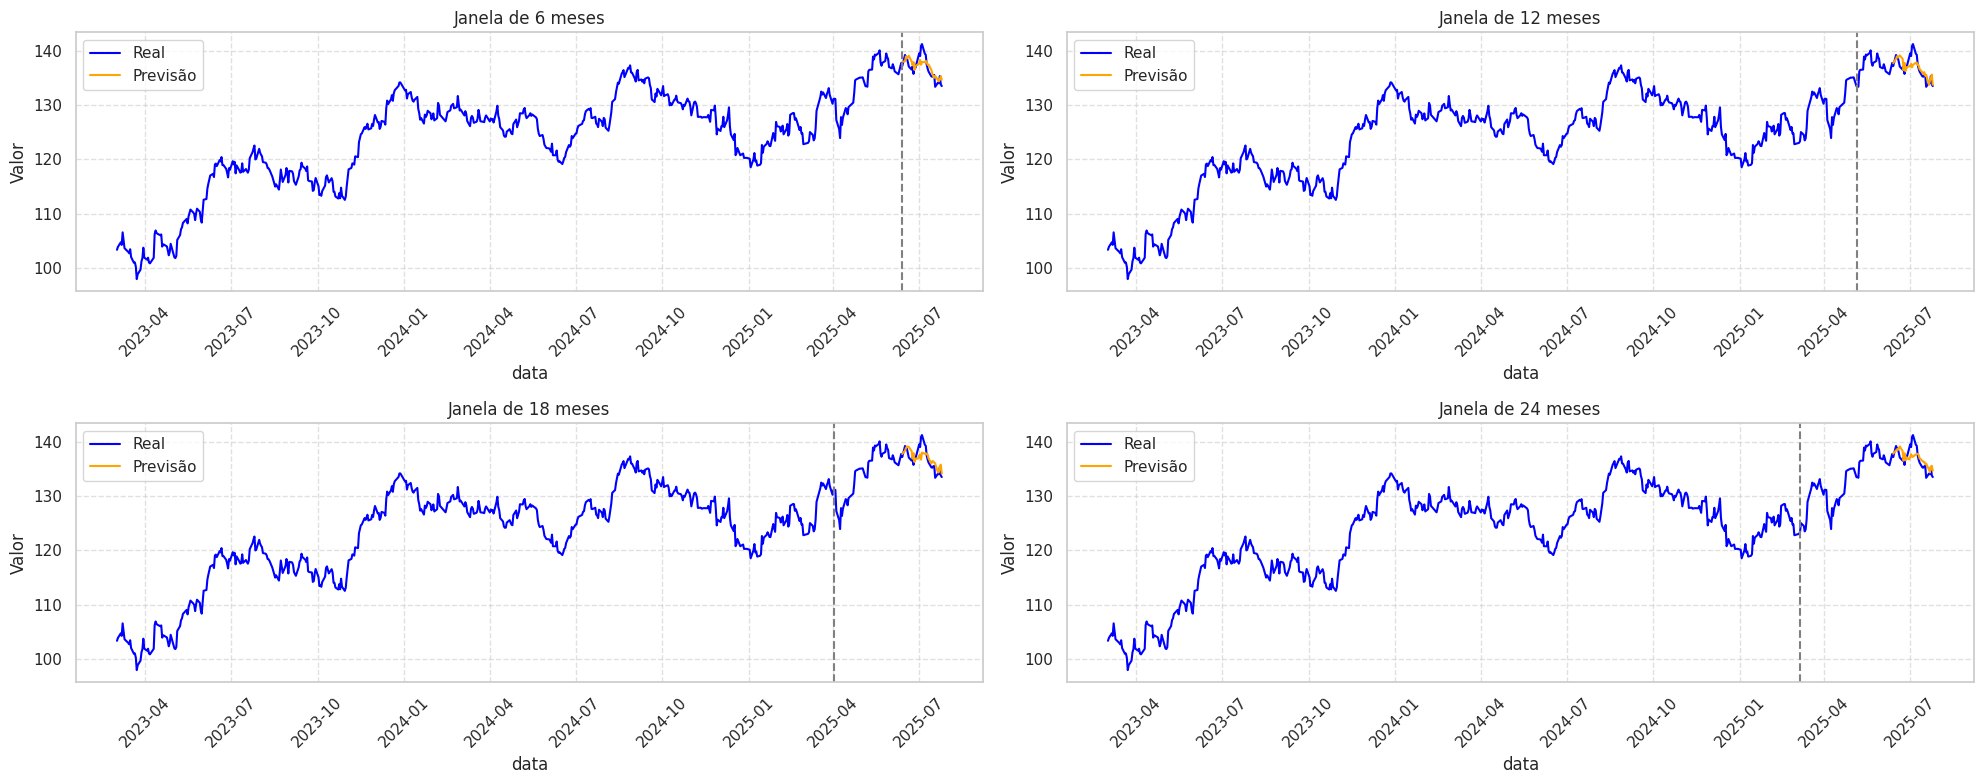

In [186]:
# Criar a grade 2x2 de subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 8))
axes = axes.flatten()

# Colunas com as previsões
predicoes = ['prediction_6meses', 'prediction_12meses', 'prediction_18meses', 'prediction_24meses']

corte   = ['2025-06-13', '2025-05-06', '2025-04-02', '2025-03-06']  # Datas de corte
titulos = ['Janela de 6 meses', 'Janela de 12 meses', 'Janela de 18 meses', 'Janela de 24 meses']

# Plot
for i in range(4):
    ax = axes[i]

    sns.lineplot(data=dfXgboostfinal, x=dfXgboostfinal.index, y='fechamento', color='blue', label='Real', ax=ax)
    sns.lineplot(data=dfXgboostfinal, x=dfXgboostfinal.index, y=predicoes[i], color='orange', label='Previsão', ax=ax)
    ax.axvline(pd.to_datetime(corte[i]), color='gray', linestyle='--')
    ax.set_title(titulos[i])
    ax.set_ylabel('Valor')
    ax.legend()
    ax.grid(linestyle='--', alpha=0.6)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


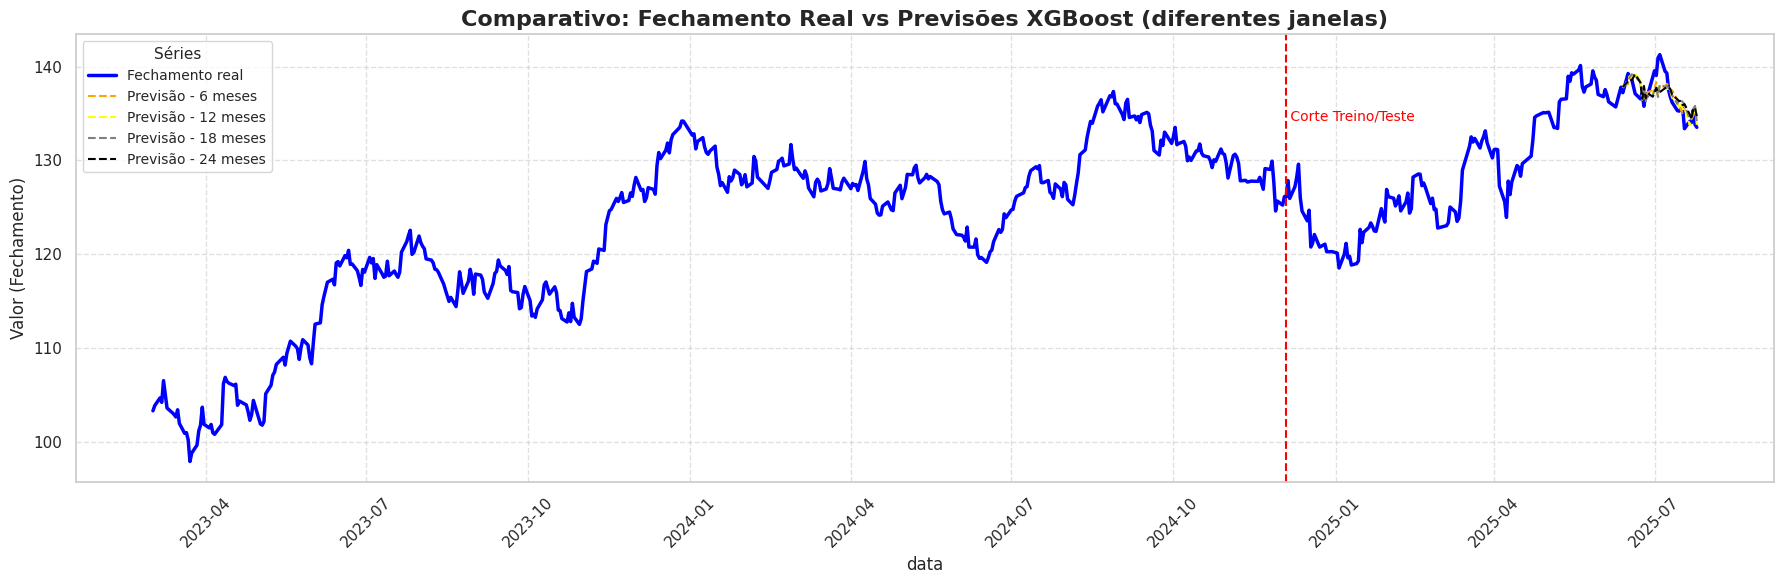

In [187]:
plt.figure(figsize=(18, 6))

# Estilo Seaborn
sns.set(style="whitegrid")

# Linha real (mais espessa)
sns.lineplot(data=dfXgboostfinal, x=dfXgboostfinal.index, y='fechamento',
             color='blue', label='Fechamento real', linewidth=2.5)

# Previsões com estilos diferentes
sns.lineplot(data=dfXgboostfinal, x=dfXgboostfinal.index, y='prediction_6meses',
             color='orange', label='Previsão - 6 meses', linestyle='--')
sns.lineplot(data=dfXgboostfinal, x=dfXgboostfinal.index, y='prediction_12meses',
             color='yellow', label='Previsão - 12 meses', linestyle='--')
sns.lineplot(data=dfXgboostfinal, x=dfXgboostfinal.index, y='prediction_18meses',
             color='gray', label='Previsão - 18 meses', linestyle='--')
sns.lineplot(data=dfXgboostfinal, x=dfXgboostfinal.index, y='prediction_24meses',
             color='black', label='Previsão - 24 meses', linestyle='--')

# Linha vertical destacando a data de corte
plt.axvline(pd.to_datetime('2024-12-04'), color='red', linestyle='--', linewidth=1.5)
plt.text(pd.to_datetime('2024-12-04'),
         dfXgboostfinal['fechamento'].max()*0.95,
         ' Corte Treino/Teste', color='red', fontsize=10)

# Eixo X com formatação de datas
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b/%Y'))
# plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45)

# Títulos e legendas
plt.title('Comparativo: Fechamento Real vs Previsões XGBoost (diferentes janelas)', fontsize=16, fontweight='bold')
plt.ylabel('Valor (Fechamento)', fontsize=12)
plt.legend(title='Séries', fontsize=10, title_fontsize=11)
plt.grid(linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


### Avaliando a acuracia

In [188]:
def tendencia(x):
    if pd.isna(x):
        return '-'
    elif x > 0:
        return 'aumento'
    elif x < 0:
        return 'queda'
    else:
        return 'estabilidade'

In [189]:
dfAcuracia = dfXgboostfinal

dfAcuracia['tendenciaOriginal'] = dfAcuracia['fechamento'].diff().apply(tendencia)

# --------------------------- 6 meses ----------------------------------------------------------------------------------------
dfAcuracia_6meses = dfAcuracia[['fechamento','prediction_6meses','tendenciaOriginal']]
dfAcuracia_6meses = dfAcuracia_6meses[dfAcuracia_6meses['prediction_6meses'].notnull()]
dfAcuracia_6meses['tendenciaPrevista_6meses'] = dfAcuracia_6meses['prediction_6meses'].diff().apply(tendencia)
dfAcuracia_6meses['Acuracia'] = dfAcuracia_6meses['tendenciaOriginal'] == dfAcuracia_6meses['tendenciaPrevista_6meses']

# --------------------------- 12 meses ----------------------------------------------------------------------------------------
dfAcuracia_12meses = dfAcuracia[['fechamento','prediction_12meses','tendenciaOriginal']]
dfAcuracia_12meses = dfAcuracia_12meses[dfAcuracia_12meses['prediction_12meses'].notnull()]
dfAcuracia_12meses['tendenciaPrevista_12meses'] = dfAcuracia_12meses['prediction_12meses'].diff().apply(tendencia)
dfAcuracia_12meses['Acuracia'] = dfAcuracia_12meses['tendenciaOriginal'] == dfAcuracia_12meses['tendenciaPrevista_12meses']

# --------------------------- 18 meses ----------------------------------------------------------------------------------------
dfAcuracia_18meses = dfAcuracia[['fechamento','prediction_18meses','tendenciaOriginal']]
dfAcuracia_18meses = dfAcuracia_18meses[dfAcuracia_18meses['prediction_18meses'].notnull()]
dfAcuracia_18meses['tendenciaPrevista_18meses'] = dfAcuracia_18meses['prediction_18meses'].diff().apply(tendencia)
dfAcuracia_18meses['Acuracia'] = dfAcuracia_18meses['tendenciaOriginal'] == dfAcuracia_18meses['tendenciaPrevista_18meses']

# --------------------------- 24 meses ----------------------------------------------------------------------------------------
dfAcuracia_24meses = dfAcuracia[['fechamento','prediction_24meses','tendenciaOriginal']]
dfAcuracia_24meses = dfAcuracia_24meses[dfAcuracia_24meses['prediction_24meses'].notnull()]
dfAcuracia_24meses['tendenciaPrevista_24meses'] = dfAcuracia_24meses['prediction_24meses'].diff().apply(tendencia)
dfAcuracia_24meses['Acuracia'] = dfAcuracia_24meses['tendenciaOriginal'] == dfAcuracia_24meses['tendenciaPrevista_24meses']

dfAcuracia_24meses.head(5)

print("Data de inicio do dataframe 6 meses :",dfAcuracia_6meses.index.min())
print("Data de inicio do dataframe 12 meses:",dfAcuracia_12meses.index.min())
print("Data de inicio do dataframe 18 meses:",dfAcuracia_18meses.index.min())
print("Data de inicio do dataframe 24 meses:",dfAcuracia_24meses.index.min())

Data de inicio do dataframe 6 meses : 2025-06-13 00:00:00
Data de inicio do dataframe 12 meses: 2025-06-13 00:00:00
Data de inicio do dataframe 18 meses: 2025-06-13 00:00:00
Data de inicio do dataframe 24 meses: 2025-06-13 00:00:00


In [190]:
dataframes = [dfAcuracia_6meses[1:len(dfAcuracia_6meses)], dfAcuracia_12meses[1:len(dfAcuracia_12meses)], dfAcuracia_18meses[1:len(dfAcuracia_18meses)], dfAcuracia_24meses[1:len(dfAcuracia_24meses)]]
nomes = ['6 meses', '12 meses', '18 meses', '24 meses']

for nome, df in zip(nomes, dataframes):
    # Quantidade de acertos (True == 1)
    acertos = df['Acuracia'].sum()

    # Total de linhas (já sem valores nulos e com tendência calculada)
    total = len(df)

    # Calcular acurácia em %
    acuracia = round(acertos / total * 100, 2)

    print(f"O modelo de XGBoost para janela de {nome} obteve uma acurácia de: {acuracia:.2f}%")

O modelo de XGBoost para janela de 6 meses obteve uma acurácia de: 48.28%
O modelo de XGBoost para janela de 12 meses obteve uma acurácia de: 44.83%
O modelo de XGBoost para janela de 18 meses obteve uma acurácia de: 48.28%
O modelo de XGBoost para janela de 24 meses obteve uma acurácia de: 41.38%
